## **Table of Contents:**
* Introduction
* The RMS Titanic
* Import Libraries
* Getting the Data
* Data Exploration/Analysis
* Data Preprocessing
    - Missing Data
    - Converting Features
    - Creating Categories
    - Creating new Features
* Building Machine Learning Models
    - Training 8 different models
    - Which is the best model ?
    - K-Fold Cross Validation
* Random Forest 
    - What is Random Forest ?
    - Feature importance
    - Hyperparameter Tuning   
* Further Evaluation 
    - Confusion Matrix
    - Precision and Recall 
    - F-Score
    - Precision Recall Curve
    - ROC AUC Curve
    - ROC AUC Score
* Submission
* Summary

# **Introduction**

In this kernel I will go through the whole process of creating a machine learning model on the famous Titanic dataset, which is used by many people all over the world. It provides information on the fate of passengers on the Titanic, summarized according to economic status (class), sex, age and survival. In this challenge, we are asked to predict whether a passenger on the titanic would have been survived or not.

# **The RMS Titanic**

RMS Titanic was a British passenger liner that sank in the North Atlantic Ocean in the early morning hours of 15 April 1912, after it collided with an iceberg during its maiden voyage from Southampton to New York City. There were an estimated 2,224 passengers and crew aboard the ship, and more than 1,500 died, making it one of the deadliest commercial peacetime maritime disasters in modern history. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

![Titanic](http://titanic2ship.com/wp-content/uploads/2013/10/ColorPlans-CyrilCodus-LG.jpg)

# **Import Libraries**

In [ ]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

# **Getting the Data**

In [ ]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# **Data Exploration/Analysis**

In [ ]:
train_df.info()

**The training-set has 891 examples and 11 features + the target variable (survived)**. 2 of the features are floats, 5 are integers and 5 are objects. Below I have listed the features with a short description:

    survival:	Survival
    PassengerId: Unique Id of a passenger.
    pclass:	Ticket class	
    sex:	Sex	
    Age:	Age in years	
    sibsp:	# of siblings / spouses aboard the Titanic	
    parch:	# of parents / children aboard the Titanic	
    ticket:	Ticket number	
    fare:	Passenger fare	
    cabin:	Cabin number	
    embarked:	Port of Embarkation

In [ ]:
train_df.describe()

Above we can see that **38% out of the training-set survived the Titanic**. We can also see that the passenger ages range from 0.4 to 80. On top of that we can already detect some features, that contain missing values, like the 'Age' feature.

In [ ]:
train_df.head(40).tail(10)

From the table above, we can note a few things. First of all, that we **need to convert a lot of features into numeric** ones later on, so that the machine learning algorithms can process them. Furthermore, we can see that the **features have widely different ranges**, that we will need to convert into roughly the same scale. We can also spot some more features, that contain missing values (NaN = not a number), that wee need to deal with.

**Let's take a more detailed look at what data is actually missing:**

In [ ]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

The Embarked feature has only 2 missing values, which can easily be filled. It will be much more tricky, to deal with the 'Age' feature, which has 177 missing values. The 'Cabin' feature needs further investigation, but it looks like that we might want to drop it from the dataset, since 77 % of it are missing.

In [ ]:
train_df.columns.values

Above you can see the 11 features + the target variable (survived). **What features could contribute to a high survival rate ?** 

To me it would make sense if everything except 'PassengerId', 'Ticket' and 'Name'  would be correlated with a high survival rate. 

**1. Age and Sex:**

In [ ]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

You can see that men have a high probability of survival when they are between 18 and 30 years old, which is also a little bit true for women but not fully. For women the survival chances are higher between 14 and 40.

For men the probability of survival is very low between the age of 5 and 18, but that isn't true for women. Another thing to note is that infants also have a little bit higher probability of survival.

Since there seem to be **certain ages, which have increased odds of survival** and because I want every feature to be roughly on the same scale, I will create age groups later on.

**3. Embarked, Pclass  and Sex:**

In [ ]:
FacetGrid = sns.FacetGrid(train_df, row='Embarked', aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Embarked seems to be correlated with survival, depending on the gender. 

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they are at port C. Men have a high survival probability if they are on port C, but a low probability if they are on port Q or S. 

Pclass also seems to be correlated with survival. We will generate another plot of it below.

**4. Pclass:**

In [ ]:
sns.barplot(x='Pclass', y='Survived', data=train_df)

Here we see clearly, that Pclass is contributing to a persons chance of survival, especially if this person is in class 1. We will create another pclass plot below.

In [ ]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass',  aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

The plot above confirms our assumption about pclass 1, but we can also spot a high probability that a person in pclass 3 will not survive.

**5.  SibSp and Parch:**

SibSp and Parch would make more sense as a combined feature, that shows the total number of relatives, a person has on the Titanic. I will create it below and also a feature that sows if someone is not alone.

In [ ]:
data = [train_df, test_df]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

In [ ]:
train_df['not_alone'].value_counts()

In [ ]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_df, aspect = 2.5, )

Here we can see that you had a high probabilty of survival with 1 to 3 realitves, but a lower one if you had less than 1 or more than 3 (except for some cases with 6 relatives).

# **Data Preprocessing**

First, I will drop 'PassengerId' from the train set, because it does not contribute to a persons survival probability. I will not drop it from the test set, since it is required there for the submission

In [ ]:
train_df = train_df.drop(['PassengerId'], axis=1)

## Missing Data:
### Cabin:
As a reminder, we have to deal with Cabin (687), Embarked (2) and Age (177). 

First I thought, we have to delete the 'Cabin' variable but then I found something interesting. A cabin number looks like ‘C123’ and the **letter refers to the deck**. 

Therefore we’re going to extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable. The missing values will be converted to zero.

In the picture below you can see the actual decks of the titanic, ranging from A to G.

![titanic decks](http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png)

In [ ]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int) 

In [ ]:
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

### Age:

Now we can tackle the issue with the age features missing values. I will create an array that contains random numbers, which are computed based on the mean age value in regards to the standard deviation and is_null.

In [ ]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

In [ ]:
train_df["Age"].isnull().sum()

### Embarked:

Since the Embarked feature has only 2 missing values, we will just fill these with the most common one.

In [ ]:
train_df['Embarked'].describe()

In [ ]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## Converting Features:

In [ ]:
train_df.info()

Above you can see that 'Fare' is a float and we have to deal with 4 categorical features: Name, Sex, Ticket and Embarked. Lets investigate and transfrom one after another.

### Fare:

Converting "Fare" from float to int64, using the "astype()" function pandas provides:

In [ ]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

### Name:
We will use the Name feature to extract the Titles from the Name, so that we can build a new feature out of that.

In [ ]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

In [ ]:
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

### Sex:

Convert 'Sex' feature into numeric.

In [ ]:
"""genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)""" 
# we can use get dummies from pandas.
train_df = pd.get_dummies(data = train_df, columns=['Sex'],drop_first=True)
test_df = pd.get_dummies(data = test_df, columns=['Sex'],drop_first=True)

### Ticket:

In [38]:
train_df['Ticket'].describe()

count        891
unique       681
top       347082
freq           7
Name: Ticket, dtype: object

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

In [39]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

### Embarked:
Convert 'Embarked' feature into numeric.

In [40]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## Creating Categories:

We will now create categories within the following features:

### Age:
Now we need to convert the 'age' feature. First we will convert it from float into integer. Then we will create the new 'AgeGroup" variable, by categorizing every age into a group. Note that it is important to place attention on how you form these groups, since you don't want for example that 80% of your data falls into group 1.

In [41]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [42]:
# let's see how it's distributed
train_df['Age'].value_counts()

6    161
4    159
5    152
3    139
2    118
1     94
0     68
Name: Age, dtype: int64

### Fare:
For the 'Fare' feature, we need to do the same as with the 'Age' feature.  But it isn't that easy, because if we cut the range of the fare values into a few equally big categories, 80% of the values would fall into the first category. Fortunately, we can use sklearn "qcut()" function, that we can use to see, how we can form the categories.

In [43]:
train_df.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Sex_male
0,0,3,2,1,0,7,0,1,0,8,1,1
1,1,1,5,1,0,71,1,1,0,3,3,0
2,1,3,3,0,0,7,0,0,1,8,2,0
3,1,1,5,1,0,53,0,1,0,3,3,0
4,0,3,5,0,0,8,0,0,1,8,1,1
5,0,3,5,0,0,8,2,0,1,8,1,1
6,0,1,6,0,0,51,0,0,1,5,1,1
7,0,3,0,3,1,21,0,4,0,8,4,1
8,1,3,3,0,2,11,0,2,0,8,3,0
9,1,2,1,1,0,30,1,1,0,8,3,0


In [44]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# Creating new Features

I will add two new features to the dataset, that I compute out of other features.

### 1. Age times Class

In [45]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

### 2.  Fare per Person

In [46]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [47]:
# Let's take a last look at the training set, before we start training the models.
train_df.head(20)

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title,Sex_male,Age_Class,Fare_Per_Person
0,0,3,2,1,0,0,0,1,0,8,1,1,6,0
1,1,1,5,1,0,3,1,1,0,3,3,0,5,1
2,1,3,3,0,0,0,0,0,1,8,2,0,9,0
3,1,1,5,1,0,3,0,1,0,3,3,0,5,1
4,0,3,5,0,0,1,0,0,1,8,1,1,15,1
5,0,3,5,0,0,1,2,0,1,8,1,1,15,1
6,0,1,6,0,0,3,0,0,1,5,1,1,6,3
7,0,3,0,3,1,2,0,4,0,8,4,1,0,0
8,1,3,3,0,2,1,0,2,0,8,3,0,9,0
9,1,2,1,1,0,2,1,1,0,8,3,0,2,1


# **Building Machine Learning Models**

In [48]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [49]:
# stochastic gradient descent (SGD) learning
sgd = linear_model.SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)


print(round(acc_sgd,2,), "%")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

In [50]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(round(acc_log,2,), "%")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(round(acc_knn,2,), "%")

In [51]:
# Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(round(acc_gaussian,2,), "%")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


In [ ]:
# Perceptron
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(round(acc_perceptron,2,), "%")

In [52]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(round(acc_linear_svc,2,), "%")

c:\Users\vusal_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


In [53]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred = decision_tree.predict(X_test)

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(round(acc_decision_tree,2,), "%")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


##  Which is the best Model ?

In [54]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

NameError: name 'acc_linear_svc' is not defined

As we can see, the Random Forest classifier goes on the first place. But first, let us check, how random-forest performs, when we use cross validation. 

## K-Fold Cross Validation:

K-Fold Cross Validation randomly splits the training data into **K subsets called folds**. Let's image we would split our data into 4 folds (K = 4).  Our random forest model would be trained and evaluated 4 times, using a different fold for evaluation everytime, while it would be trained on the remaining 3 folds. 

The image below shows the process, using 4 folds (K = 4). Every row represents one training + evaluation process. In the first row, the model get's trained on the first, second and third subset and evaluated on the fourth. In the second row, the model get's trained on the second, third and fourth subset and evaluated on the first. K-Fold Cross Validation repeats this process till every fold acted once as an evaluation fold.


![cross-v.](https://img3.picload.org/image/ddwrppcl/bildschirmfoto2018-02-02um10.0.png)

The result of our K-Fold Cross Validation example would be an array that contains 4 different scores. We then need to compute the mean and the standard deviation for these scores. 

The code below perform K-Fold Cross Validation on our random forest model, using 10 folds (K = 10). Therefore it outputs an array with 10 different scores.

In [55]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")

In [56]:
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.76666667 0.84269663 0.75280899 0.84269663 0.88764045 0.84269663
 0.82022472 0.7752809  0.86516854 0.84269663]
Mean: 0.8238576779026217
Standard Deviation: 0.042291941793889315


This looks much more realistic than before.  Our model has a average accuracy of 82% with a standard deviation of 4 %. The standard deviation shows us, how precise the estimates are . 

This means in our case that the accuracy of our model can differ **+ -** 4%.

I think the accuracy is still really good and since random forest is an easy to use model, we will try to increase it's performance even further in the following section.

# **Random Forest**

## What is Random Forest ?

Random Forest is a supervised learning algorithm. Like you can already see from it’s name, it creates a forest and makes it somehow random. The „forest“ it builds, is an ensemble of Decision Trees, most of the time trained with the “bagging” method. The general idea of the bagging method is that a combination of learning models increases the overall result.

To say it in simple words: Random forest builds multiple decision trees and merges them together to get a more accurate and stable prediction.

One big advantage of random forest is, that it can be used for both classification and regression problems, which form the majority of current machine learning systems.  With a few exceptions a random-forest classifier has all the hyperparameters of a decision-tree classifier and also all the hyperparameters of a bagging classifier, to control the ensemble itself. 

The random-forest algorithm brings extra randomness into the model, when it is growing the trees. Instead of searching for the best feature while splitting a node, it searches for the best feature among a random subset of features. This process creates a wide diversity, which generally results in a better model. Therefore when you are growing a tree in random forest, only a random subset of the features is considered for splitting a node. You can even make trees more random, by using random thresholds on top of it, for each feature rather than searching for the best possible thresholds (like a normal decision tree does).

Below you can see how a random forest would look like with two trees:

![picture](https://img3.picload.org/image/dagpgdpw/bildschirmfoto-2018-02-06-um-1.png)

## Feature Importance

Another great quality of random forest is that  they make it very easy to measure the relative importance of each feature. Sklearn measure a features importance by looking at how much the treee nodes, that use that feature, reduce impurity on average (across all trees in the forest). It computes this score automaticall for each feature after training and scales the results  so that the sum of all importances is equal to 1.  We will acces this below:

In [57]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')

NameError: name 'random_forest' is not defined

In [ ]:
importances.head(15)

In [ ]:
importances.plot.bar()

**Conclusion:**

not_alone and Parch doesn't play a significant role in our random forest classifiers prediction process. Because of that I will drop them from the dataset and train the classifier again. We could also remove more or less features, but this would need a more detailed investigation of the features effect on our model. But I think it's just fine to remove only Alone and Parch.

In [ ]:
train_df  = train_df.drop("not_alone", axis=1)
test_df  = test_df.drop("not_alone", axis=1)

train_df  = train_df.drop("Parch", axis=1)
test_df  = test_df.drop("Parch", axis=1)

**Training random forest again:**

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

Our random forest model predicts as good as it did before. A general rule is that,  **the more features you have, the more likely your model will suffer from overfitting** and vice versa. But I think our data looks fine for now and hasn't too much features.

There is also another way to evaluate a random-forest classifier, which is probably much more accurate than the score we used before. What I am talking about is the **out-of-bag samples** to estimate the generalization accuracy. I will not go into details here about how it works. Just note that out-of-bag estimate is as accurate as using a test set of the same size as the training set. Therefore, using the out-of-bag error estimate removes the need for a set aside test set.

In [ ]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

Now we can start tuning the hyperameters of random forest. 

## Hyperparameter Tuning

Below you can see the code of the hyperparamter tuning for the parameters criterion, min_samples_leaf, min_samples_split and n_estimators. 

I put this code into a markdown cell and not into a code cell, because it takes a long time to run it. Directly underneeth it, I put a screenshot of the gridsearch's output.

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10, 25, 50, 70], 
              "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], 
              "n_estimators": [100, 400, 700, 1000, 1500]}


from sklearn.model_selection import GridSearchCV, cross_val_score

rf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1, n_jobs=-1)

clf = GridSearchCV(estimator=rf, param_grid=param_grid,
                    n_jobs=-1)

clf.fit(X_train, Y_train)        

clf.best_params_

![GridSearch Output](https://img2.picload.org/image/ddwglili/bildschirmfoto2018-02-01um15.4.png)

**Test new paramters:**

In [58]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, Y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

c:\Users\vusal_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Sex
Feature names seen at fit time, yet now missing:
- Sex_male


Now that we have a proper model, we can start evaluating it's performace in a more accurate way. Previously we only used accuracy and the oob score, which is just another form of accuracy. The problem is just, that it's more complicated to evaluate a classification model than a regression model. We will talk about this in the following section.

# **Further Evaluation**



## Confusion Matrix:

In [59]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

c:\Users\vusal_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\vusal_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
c:\Users\vusal_u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:425: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, ex

array([[493,  56],
       [ 97, 245]], dtype=int64)

The first row is about the not-survived-predictions: **493 passengers were correctly classified as not survived** (called true negatives)  and **56 where wrongly classified as not survived** (false positives).

The second row is about the survived-predictions: **93 passengers where wrongly classified as survived** (false negatives) and **249 where correctly classified as survived** (true positives).

A confusion matrix gives you a lot of information about how well your model does, but theres a way to get even more, like computing the classifiers precision.

## Precision and Recall:

In [60]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.813953488372093
Recall: 0.716374269005848


Our model predicts 81% of the time, a passengers survival correctly (precision). The recall tells us that it predicted the survival of 73 % of the people who actually survived. 

## F-Score

You can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [61]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.7620528771384137

There we have it, a 77 % F-score. The score is not that high, because we have a recall of 73%.

But unfortunately the F-score is not perfect, because it favors classifiers that have a similar precision and recall. This is a problem, because you sometimes want a high precision and sometimes a high recall. The thing is that an increasing precision, sometimes results in an decreasing recall and vice versa (depending on the threshold). This is called the precision/recall tradeoff. We will discuss this in the following section.


## Precision Recall Curve

For each person the Random Forest algorithm has to classify, it computes a probability based on a function and it classifies the person as survived (when the score is bigger the than threshold) or as not survived (when the score is smaller than the threshold). That's why the threshold plays an important part.

We will plot the precision and recall with the threshold using matplotlib:

In [62]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)

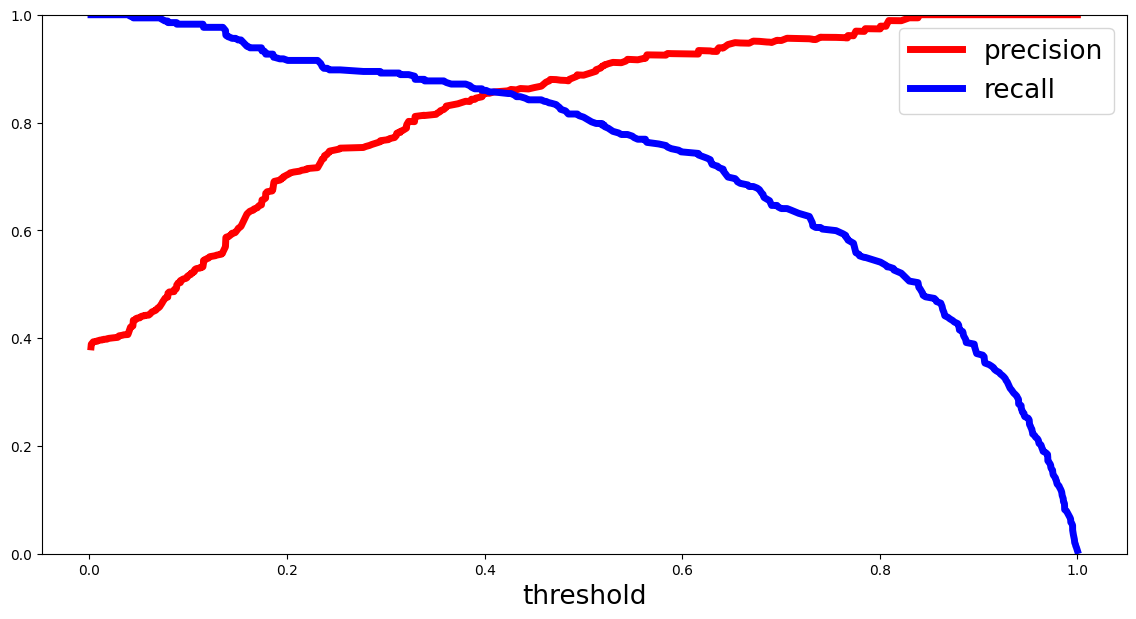

In [63]:
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Above you can clearly see that the recall is falling of rapidly at a precision of around 85%.  Because of that you may want to select the precision/recall tradeoff before that - maybe at around 75 %.

You are now able to choose a threshold, that gives you the best precision/recall tradeoff for your current machine learning problem. If you want for example a precision of 80%, you can easily look at the plots and see that you would need a threshold of around 0.4.  Then you could train a model with exactly that threshold and would get the desired accuracy.


Another way is to plot the precision and recall against each other:

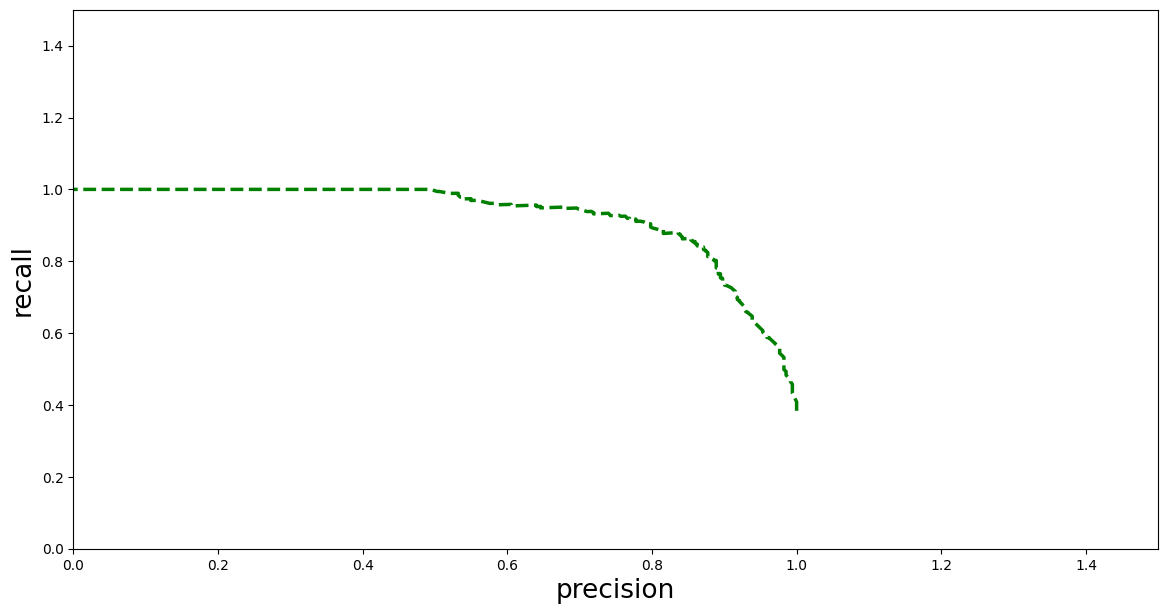

In [64]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC AUC Curve

Another way to evaluate and compare your binary classifier is provided by the ROC AUC Curve. This curve plots the true positive rate (also called recall) against the false positive rate (ratio of incorrectly classified negative instances), instead of plotting the precision versus the recall.

In [65]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)

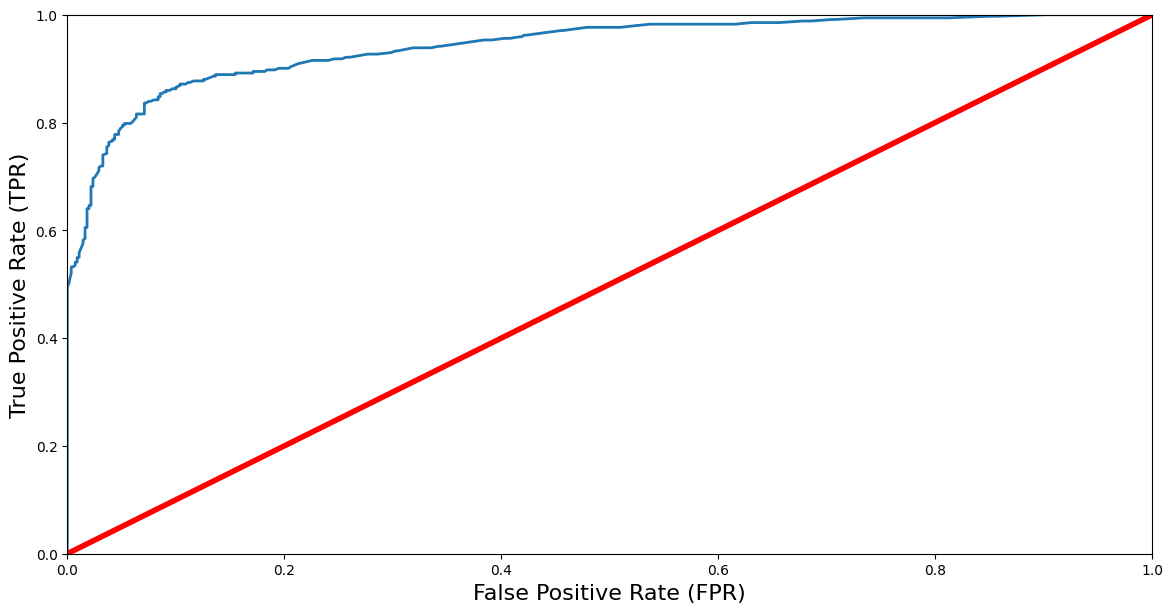

In [66]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

The red line in the middel represents a purely random classifier (e.g a coin flip) and therefore your classifier should be as far away from it as possible. Our Random Forest model seems to do a good job. 

Of course we also have a tradeoff here, because the classifier produces more false positives, the higher the true positive rate is. 

## ROC AUC Score
The ROC AUC Score is the corresponding score to the ROC AUC Curve. It is simply computed by measuring the area under the curve, which is called AUC. 

A classifiers that is 100% correct, would have a ROC AUC Score of 1 and a completely random classiffier would have a score of 0.5.

In [67]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9422767605108703


Nice ! I think that score is good enough to submit the predictions for the test-set to the Kaggle leaderboard.

# **Submission**

In [68]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_prediction
    })
submission.to_csv('submission.csv', index=False)

NameError: name 'Y_prediction' is not defined

# **Summary**

This project deepened my machine learning knowledge significantly and I strengthened my ability to apply concepts that I learned from textbooks, blogs and various other sources, on a different type of problem. This project had a heavy focus on the data preparation part, since this is what data scientists work on most of their time. 

I started with the data exploration where I got a feeling for the dataset, checked about missing data and learned which features are important. During this process I used seaborn and matplotlib to do the visualizations. During the data preprocessing part, I computed missing values, converted features into numeric ones, grouped values into categories and created a few new features. Afterwards I started training 8 different machine learning models, picked one of them (random forest) and applied cross validation on it. Then I explained how random forest works, took a look at the importance it assigns to the different features and tuned it's performace through optimizing it's hyperparameter values.  Lastly I took a look at it's confusion matrix and computed the models precision, recall and f-score, before submitting my predictions on the test-set to the Kaggle leaderboard.

Below you can see a before and after picture of the train_df dataframe:

![Titanic](https://img1.picload.org/image/dagldoor/before_after.png)


Of course there is still room for improvement, like doing a more extensive feature engineering, by comparing and plotting the features against each other and identifying and removing the noisy features. Another thing that can improve the overall result on the kaggle leaderboard would be a more extensive hyperparameter tuning on several machine learning models. Of course you could also do some ensemble learning.